### Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

### Splitting the Dataset

In [6]:
#Generate batches of tensor image data with real-time data augmentation.

train_set = r"C:\Users\khush\Documents\Intern\IEEE Covid\training"
test_set = r"C:\Users\khush\Documents\Intern\IEEE Covid\test"
val_set = r"C:\Users\khush\Documents\Intern\IEEE Covid\validation"

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_directory(train_set,
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_directory(test_set,
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_directory(val_set,
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3228 images belonging to 4 classes.
Found 1076 images belonging to 4 classes.
Found 1076 images belonging to 4 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [8]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

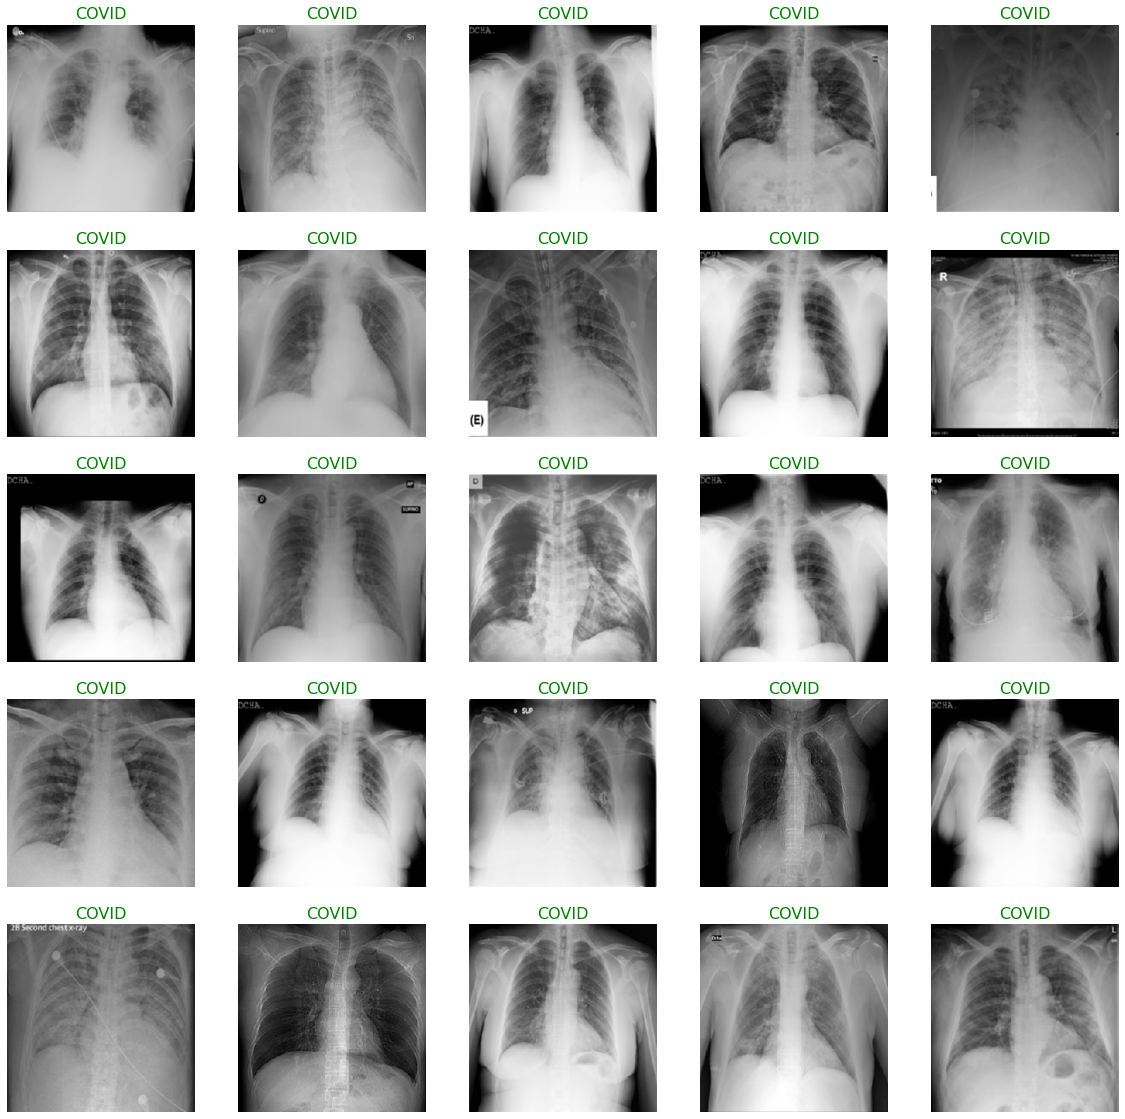

In [9]:
show_images(train)

### VGG-16

In [10]:
from keras.applications.vgg16 import VGG16, preprocess_input
IMG_SIZE=(224,224)
# vgg16_weight_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
NUM_CLASSES = 4
from keras import layers
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
#fitting model
import time

start = time.time()
History = model.fit(train,validation_data= val, epochs=25,verbose=1)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/25
101/101 [==============================] - 293s 3s/step - loss: 0.5423 - accuracy: 0.4449 - val_loss: 0.3327 - val_accuracy: 0.8476
Epoch 2/25
101/101 [==============================] - 538s 5s/step - loss: 0.3606 - accuracy: 0.7004 - val_loss: 0.2717 - val_accuracy: 0.7862
Epoch 3/25
101/101 [==============================] - 720s 7s/step - loss: 0.2933 - accuracy: 0.7782 - val_loss: 0.2464 - val_accuracy: 0.8095
Epoch 4/25
101/101 [==============================] - 719s 7s/step - loss: 0.2615 - accuracy: 0.8073 - val_loss: 0.1973 - val_accuracy: 0.8820
Epoch 5/25
101/101 [==============================] - 719s 7s/step - loss: 0.2281 - accuracy: 0.8333 - val_loss: 0.1728 - val_accuracy: 0.8931
Epoch 6/25
101/101 [==============================] - 719s 7s/step - loss: 0.2082 - accuracy: 0.8603 - val_loss: 0.1792 - val_accuracy: 0.8810
Epoch 7/25
101/101 [==============================] - 723s 7s/step - loss: 0.1904 - accuracy: 0.8752 - val_loss: 0.1808 - val_accuracy: 0.8643

Text(0.5, 1.0, 'Training and Validation Accuracy')

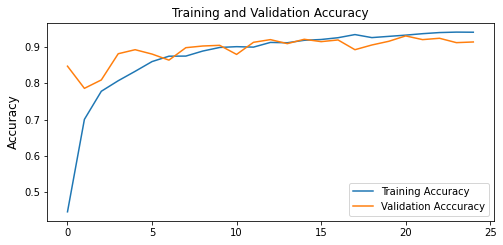

In [13]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

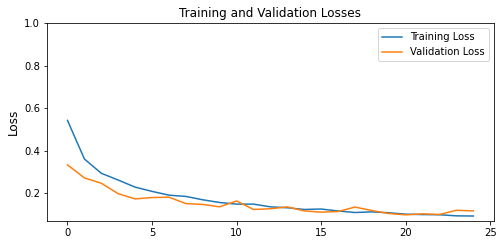

In [14]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [15]:
model.evaluate(test, verbose=1)

34/34 [==============================] - 66s 2s/step - loss: 0.1358 - accuracy: 0.8978


[0.1357690989971161, 0.8977695107460022]

In [16]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

34/34 [==============================] - 67s 2s/step


In [17]:
from sklearn.metrics import classification_report,accuracy_score

y_test = test.labels # set y_test to the expected output

listt = {0: 'COVID',1: 'Lung_Opacity',2: 'Normal', 3:'Viral Pneumonia'}
y_test = [listt[i] for i in y_test]

print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

                 precision    recall  f1-score   support

          COVID       0.79      0.98      0.88       269
   Lung_Opacity       0.99      0.75      0.85       269
         Normal       0.91      0.94      0.92       269
Viral Pneumonia       0.95      0.92      0.93       269

       accuracy                           0.90      1076
      macro avg       0.91      0.90      0.90      1076
   weighted avg       0.91      0.90      0.90      1076

Accuracy of the Model: 89.77695167286245 %


<AxesSubplot:>

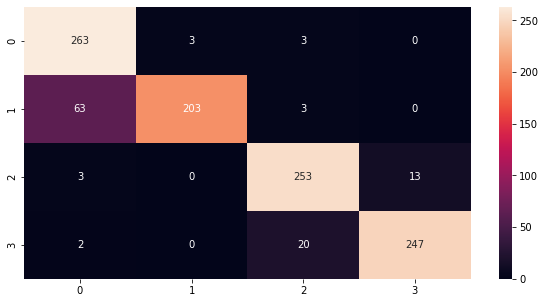

In [18]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

### VGG-19

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
#vgg = VGG19(weights="../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top = False,input_shape=(224,244,3))
vgg = VGG19(weights="imagenet",
            include_top = False,input_shape=(224,224,3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(NUM_CLASSES,activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#fitting model
import time

start = time.time()
History = model.fit(train,validation_data= val, epochs=25,verbose=1)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/25
101/101 [==============================] - 838s 8s/step - loss: 0.6773 - accuracy: 0.5914 - val_loss: 0.2329 - val_accuracy: 0.8160
Epoch 2/25
101/101 [==============================] - 900s 9s/step - loss: 0.2533 - accuracy: 0.8169 - val_loss: 0.2323 - val_accuracy: 0.8411
Epoch 3/25
101/101 [==============================] - 895s 9s/step - loss: 0.2162 - accuracy: 0.8634 - val_loss: 0.1167 - val_accuracy: 0.9043
Epoch 4/25
101/101 [==============================] - 897s 9s/step - loss: 0.1141 - accuracy: 0.9188 - val_loss: 0.1583 - val_accuracy: 0.8755
Epoch 5/25
101/101 [==============================] - 898s 9s/step - loss: 0.1504 - accuracy: 0.8931 - val_loss: 0.1906 - val_accuracy: 0.8875
Epoch 6/25
101/101 [==============================] - 898s 9s/step - loss: 0.0942 - accuracy: 0.9390 - val_loss: 0.1011 - val_accuracy: 0.9219
Epoch 7/25
101/101 [==============================] - 898s 9s/step - loss: 0.0952 - accuracy: 0.9325 - val_loss: 0.2017 - val_accuracy: 0.8625

Text(0.5, 1.0, 'Training and Validation Accuracy')

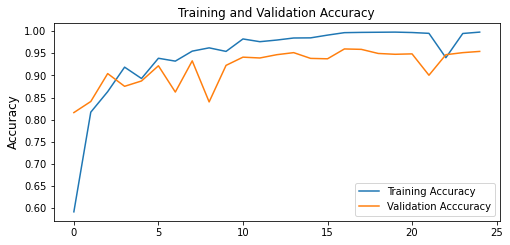

In [21]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

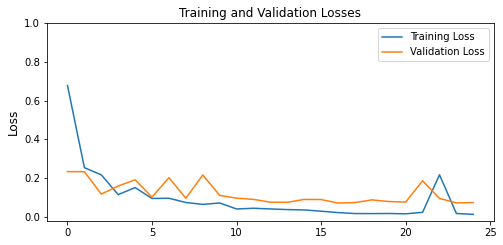

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [23]:
model.evaluate(test, verbose=1)

34/34 [==============================] - 223s 7s/step - loss: 0.1049 - accuracy: 0.9377


[0.10491431504487991, 0.9377323389053345]

In [24]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

34/34 [==============================] - 223s 7s/step


In [25]:
from sklearn.metrics import classification_report,accuracy_score

y_test = test.labels # set y_test to the expected output

listt = {0: 'COVID',1: 'Lung_Opacity',2: 'Normal', 3:'Viral Pneumonia'}
y_test = [listt[i] for i in y_test]

print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

                 precision    recall  f1-score   support

          COVID       0.92      0.97      0.94       269
   Lung_Opacity       0.96      0.93      0.94       269
         Normal       0.96      0.90      0.93       269
Viral Pneumonia       0.92      0.96      0.94       269

       accuracy                           0.94      1076
      macro avg       0.94      0.94      0.94      1076
   weighted avg       0.94      0.94      0.94      1076

Accuracy of the Model: 93.77323420074349 %


<AxesSubplot:>

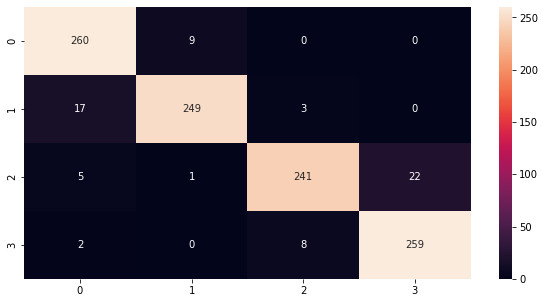

In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')